In [ ]:
import copy
import torch, torchvision
from torchvision import transforms
from torch import nn
from torch import optim
from torch.autograd import Variable as var
import matplotlib.pyplot as plt
import time
import requests
import numpy as np
from PIL import Image
from io import BytesIO
from torchvision.transforms import ToTensor
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

In [ ]:
numb_batch = 64
learning_rate = 0.01
numb_epoch = 5

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [ ]:
valid_T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

train_T = transforms.Compose(
                    [
                    # transforms.RandomRotation(30),
                    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5], std=[0.5])
                    ])

train_data = torchvision.datasets.EMNIST('Emnist_data', train=True, download=True, transform=valid_T, split="letters")
val_data = torchvision.datasets.EMNIST('Emnist_data', train=False, download=True, transform=valid_T, split="letters")

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)

Extracting Emnist_data/EMNIST/raw/emnist.zip to Emnist_data/EMNIST/raw
Processing byclass


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


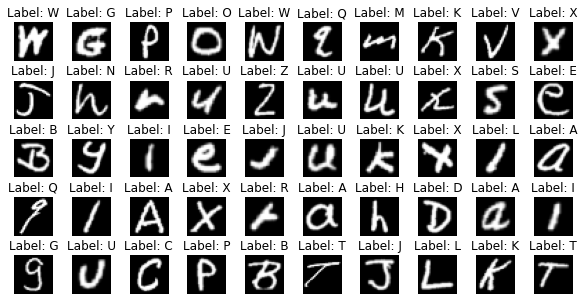

In [ ]:
fig = plt.figure(figsize=(10, 5))
for i in range(50):
    fig.add_subplot(5, 10, i+1)
    plt.axis('off')
    img = train_data[i][0].squeeze(0).T
    label = train_data[i][1]
    plt.title('Label: ' + chr(label+64))
    plt.imshow(img, cmap='gray')
plt.subplots_adjust(wspace=0.5, hspace=0.5)

In [ ]:
len(train_data.classes)

26

In [ ]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=3),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        
        nn.Conv2d(6, 16, 3, padding=3),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        
        nn.Flatten(),
        nn.Linear(1296, 400),
        nn.ReLU(),
        nn.Linear(400, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 26)
    )
    return model

In [ ]:
model = create_lenet()
model(torch.from_numpy(np.random.randn(8, 1, 28, 28).astype(np.float32))).shape

torch.Size([8, 26])

In [ ]:
def validate(model, data):
    total = 0
    correct = 0
    for i,(images,labels) in enumerate(data):
        images = images.cuda()
        x = torch.transpose(images, 2, 3)
        x = model(x)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += len(labels)
        correct += torch.sum(pred == labels)
    return correct*100./total

In [ ]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            x = torch.transpose(images, 2, 3)

            optimizer.zero_grad()
            pred = cnn(x)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            # torch.save(best_model.state_dict(), "lenet.pth")
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch :', epoch+1, "Accuracy :", accuracy, '%')
    return best_model

In [ ]:
model = train(5, device=device)

Saving Best Model with Accuracy:  84.11538696289062
Epoch : 1 Accuracy : 84.11538696289062 %
Saving Best Model with Accuracy:  86.47595977783203
Epoch : 2 Accuracy : 86.47595977783203 %
Saving Best Model with Accuracy:  87.07211303710938
Epoch : 3 Accuracy : 87.07211303710938 %
Saving Best Model with Accuracy:  88.04808044433594
Epoch : 4 Accuracy : 88.04808044433594 %
Saving Best Model with Accuracy:  88.36058044433594
Epoch : 5 Accuracy : 88.36058044433594 %


In [ ]:
lenet = create_lenet().to(device)
lenet.load_state_dict(torch.load("lenet.pth"))
lenet.eval()

In [ ]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images,labels) in enumerate(data):
        images = images.cuda()
        x = torch.transpose(images, 2, 3)
        x = model(x)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [ ]:
y_pred, y_true = predict_dl(model, val_dl)

In [ ]:
labels = [ch for ch in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ']

In [ ]:
pd.set_option("display.max_columns", 26)

In [ ]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0, 26)), index=labels, columns=labels)

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B,4,747,0,1,2,3,0,3,6,0,0,0,0,1,3,3,1,17,2,0,0,7,0,0,0,0
C,5,4,733,0,0,1,0,9,31,0,0,2,4,0,2,0,1,3,3,0,1,1,0,0,0,0
D,0,0,0,772,3,7,0,2,0,0,0,0,8,0,0,1,0,0,1,1,1,4,0,0,0,0
E,0,6,1,0,751,0,0,2,2,0,9,0,0,0,1,20,2,5,0,0,0,1,0,0,0,0
F,1,6,1,20,0,754,0,2,0,1,1,0,3,0,0,0,2,2,2,1,3,1,0,0,0,0
G,0,1,0,0,0,2,750,3,1,0,1,0,4,0,0,0,13,4,1,1,19,0,0,0,0,0
H,2,15,2,2,2,0,1,606,1,0,7,1,2,0,1,1,1,149,1,3,0,0,0,0,0,3
I,1,3,0,0,0,0,0,0,768,0,0,2,6,0,16,0,0,0,0,0,0,4,0,0,0,0
J,1,0,0,1,0,1,0,0,3,677,12,0,101,0,1,0,0,0,0,0,0,0,1,1,1,0
